In [1]:
def CRRA(m,cons):
        """
        ------------------------------
        === CRRA Utility Function ===
        ------------------------------
        <inputs>
        ・m: パラメータ等を格納したコンストラクタ
        ・cons: 消費量
        ・gamma: 異時点間の代替弾力性の逆数(相対的リスク回避度)
        <output>
        ・consとgamma の下での効用水準
        """
        import numpy as np
        gamma = m.gamma
        
        if cons <0: 
            utility = -10000 #消費量が負値の場合、ペナルティを与える(最適化問題におけるトリック)
        else:
            if gamma != 1.0:
                utility = (cons ** (1-gamma)) / (1-gamma)
            else:
                utility = np.log(cons)
                
        return utility

In [2]:
#カリブレーション
class Model():
    """
    ロビンソン・クルーソーモデルを解くためのパラメータを含む class を定義する。
    """
    def __init__(self,
        beta = 0.985, # 割引因子
        gamma = 1.0, # 異時点間の代替弾力性の逆数
        rent = 1.01-1.0,
        wH = 1.0,
        wL = 0.1,
        p1 = 0.9,
        p2 = 0.9,
        na = 501,     # 資本のグリッド数
        amax = 10.0, #1.0,  # 資本グリッドの最大値
        amin = -1.0, #0.05, # 資本グリッドの最小値
        maxit = 10000, # 繰り返し計算の最大値
        tol = 1e-5,   # 許容誤差(STEP 4)
        ): 
        
        self.beta, self.gamma, self.rent = beta, gamma, rent 
        self.wH, self.wL, self.p1, self.p2 = wH, wL, p1, p2 
        self.na, self.amax, self.amin = na, amax, amin 
        self.maxit, self.tol = maxit, tol
        self.agrid = np.linspace(amin,amax,na) # 資本のグリッド

In [3]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from functools import partial
import matplotlib.pyplot as plt
import japanize_matplotlib

In [12]:
#収束に関するパラメータ
it = 1 #ループカウンター
dif1 = 1.0 #価値関数の繰り返し誤差
dif2 = 1.0 #政策関数の繰り返し誤差

#STEP 1(b): 価値関数・政策関数の初期値を設定
m = Model()
vfcn = np.ones((m.na,2)) # it should be large enough
pfcn = np.ones_like(vfcn)
Tvfcn = np.zeros_like(vfcn)
Tpfcn = np.zeros_like(vfcn)
vkp1 = np.empty((m.na,m.na))
vkp2 = np.empty((m.na,m.na))
# v_conv = [] #価値関数の繰り返し誤差を記録していく。各繰り返しごとにリストに追加していく。
# p_conv = [] #政策関数の繰り返し誤差を記録していく。

In [5]:
#STEP 2: 効用関数の組み合わせ

#効用関数の初期値(消費が0以下になる組み合わせにはペナルティ)
#MATLABコード上はループで明示的にペナルティを与えているが、pythonコードではCRRA関数において先に負の消費にペナルティを与えている。
util = -10000.0*np.ones((m.na,m.na,2))

#(k,k')の組み合わせについて効用を計算
for i in range(m.na): #今期の資本量
    for j in range(m.na): #来期の資本量
        
        cH = (1.0+m.rent)*m.agrid[i] - m.agrid[j] + m.wH
        cL = (1.0+m.rent)*m.agrid[i] - m.agrid[j] + m.wL
        
        if cH > 0.0:
            util[i,j,0] = CRRA(m,cH)
        if cL > 0.0:
            util[i,j,1] = CRRA(m,cL)

In [6]:
print(util[0,0,0])
print(m.wH)
# print(util[10,1,1])

-0.01005033585350145
1.0


In [13]:
#STEP 3: 価値関数を繰り返し計算

while (it<m.maxit) & (dif1>m.tol):

    #ベルマン方程式: V(k;k')
    for i in range(m.na):
        
        vkp1[i,:] = util[i,:,0] + m.beta*(m.p1*vfcn[:,0]+(1-m.p1)*vfcn[:,1])
        vkp2[i,:] = util[i,:,1] + m.beta*(m.p2*vfcn[:,0]+(1-m.p2)*vfcn[:,1])
        
        #最適化: 各kについてV(k,k')を最大にするk'を探す
        ploc1 = np.argmax(vkp1[i,:])
        Tvfcn[i,0] = vkp1[i,ploc1]
        Tpfcn[i,0] = m.agrid[ploc1]
        ploc2 = np.argmax(vkp2[i,:])
        Tvfcn[i,1] = vkp2[i,ploc2]
        Tpfcn[i,1] = m.agrid[ploc2]
    
    #繰り返し誤差を確認
    dif1 = np.max(np.abs(Tvfcn-vfcn))
    dif2 = np.max(np.abs(Tpfcn-pfcn)) 
#     dif1 = np.max(np.abs((Tvfcn-vfcn)/vfcn))
#     dif2 = np.max(np.abs((Tpfcn-pfcn)/pfcn)) 
    
    #価値関数・政策関数をアップデート
    vfcn = np.copy(Tvfcn)
    pfcn = np.copy(Tpfcn)

    print(f"iteration index: {it}, iteration diff of value: {dif1:.7f}")

    #収束途中の繰り返し計算誤差を保存
#     v_conv.append(dif1)
#     p_conv.append(dif2)

    it += 1

iteration index: 1, iteration diff of value: 2.4782055
iteration index: 2, iteration diff of value: 1.2151281
iteration index: 3, iteration diff of value: 0.8144703
iteration index: 4, iteration diff of value: 0.5892229
iteration index: 5, iteration diff of value: 0.4428905
iteration index: 6, iteration diff of value: 0.3402941
iteration index: 7, iteration diff of value: 0.2647896
iteration index: 8, iteration diff of value: 0.2072856
iteration index: 9, iteration diff of value: 0.1623980
iteration index: 10, iteration diff of value: 0.1266397
iteration index: 11, iteration diff of value: 0.1217992
iteration index: 12, iteration diff of value: 0.1186538
iteration index: 13, iteration diff of value: 0.1156944
iteration index: 14, iteration diff of value: 0.1130725
iteration index: 15, iteration diff of value: 0.1106030
iteration index: 16, iteration diff of value: 0.1084171
iteration index: 17, iteration diff of value: 0.1063048
iteration index: 18, iteration diff of value: 0.1041094
i

iteration index: 151, iteration diff of value: 0.0134549
iteration index: 152, iteration diff of value: 0.0132531
iteration index: 153, iteration diff of value: 0.0130543
iteration index: 154, iteration diff of value: 0.0128585
iteration index: 155, iteration diff of value: 0.0126656
iteration index: 156, iteration diff of value: 0.0124756
iteration index: 157, iteration diff of value: 0.0122885
iteration index: 158, iteration diff of value: 0.0121041
iteration index: 159, iteration diff of value: 0.0119226
iteration index: 160, iteration diff of value: 0.0117437
iteration index: 161, iteration diff of value: 0.0115676
iteration index: 162, iteration diff of value: 0.0113941
iteration index: 163, iteration diff of value: 0.0112232
iteration index: 164, iteration diff of value: 0.0110548
iteration index: 165, iteration diff of value: 0.0108890
iteration index: 166, iteration diff of value: 0.0107257
iteration index: 167, iteration diff of value: 0.0105648
iteration index: 168, iteration

iteration index: 296, iteration diff of value: 0.0015036
iteration index: 297, iteration diff of value: 0.0014811
iteration index: 298, iteration diff of value: 0.0014588
iteration index: 299, iteration diff of value: 0.0014370
iteration index: 300, iteration diff of value: 0.0014154
iteration index: 301, iteration diff of value: 0.0013942
iteration index: 302, iteration diff of value: 0.0013733
iteration index: 303, iteration diff of value: 0.0013527
iteration index: 304, iteration diff of value: 0.0013324
iteration index: 305, iteration diff of value: 0.0013124
iteration index: 306, iteration diff of value: 0.0012927
iteration index: 307, iteration diff of value: 0.0012733
iteration index: 308, iteration diff of value: 0.0012542
iteration index: 309, iteration diff of value: 0.0012354
iteration index: 310, iteration diff of value: 0.0012169
iteration index: 311, iteration diff of value: 0.0011986
iteration index: 312, iteration diff of value: 0.0011806
iteration index: 313, iteration

iteration index: 445, iteration diff of value: 0.0001582
iteration index: 446, iteration diff of value: 0.0001558
iteration index: 447, iteration diff of value: 0.0001535
iteration index: 448, iteration diff of value: 0.0001512
iteration index: 449, iteration diff of value: 0.0001489
iteration index: 450, iteration diff of value: 0.0001467
iteration index: 451, iteration diff of value: 0.0001445
iteration index: 452, iteration diff of value: 0.0001423
iteration index: 453, iteration diff of value: 0.0001402
iteration index: 454, iteration diff of value: 0.0001381
iteration index: 455, iteration diff of value: 0.0001360
iteration index: 456, iteration diff of value: 0.0001339
iteration index: 457, iteration diff of value: 0.0001319
iteration index: 458, iteration diff of value: 0.0001300
iteration index: 459, iteration diff of value: 0.0001280
iteration index: 460, iteration diff of value: 0.0001261
iteration index: 461, iteration diff of value: 0.0001242
iteration index: 462, iteration

iteration index: 597, iteration diff of value: 0.0000159
iteration index: 598, iteration diff of value: 0.0000157
iteration index: 599, iteration diff of value: 0.0000154
iteration index: 600, iteration diff of value: 0.0000152
iteration index: 601, iteration diff of value: 0.0000150
iteration index: 602, iteration diff of value: 0.0000147
iteration index: 603, iteration diff of value: 0.0000145
iteration index: 604, iteration diff of value: 0.0000143
iteration index: 605, iteration diff of value: 0.0000141
iteration index: 606, iteration diff of value: 0.0000139
iteration index: 607, iteration diff of value: 0.0000137
iteration index: 608, iteration diff of value: 0.0000135
iteration index: 609, iteration diff of value: 0.0000133
iteration index: 610, iteration diff of value: 0.0000131
iteration index: 611, iteration diff of value: 0.0000129
iteration index: 612, iteration diff of value: 0.0000127
iteration index: 613, iteration diff of value: 0.0000125
iteration index: 614, iteration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


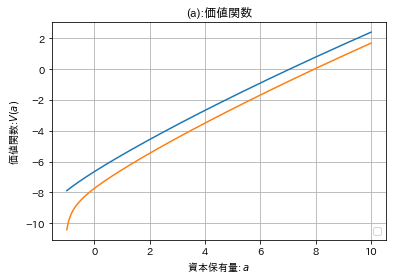

In [9]:
fig, ax = plt.subplots()
ax.plot(m.agrid,vfcn[:,0])
ax.plot(m.agrid,vfcn[:,1])
ax.set(title="(a):価値関数",xlabel=r"資本保有量: $a$", ylabel=r"価値関数:$V(a)$") #,xlim=(0,m.kmax))
ax.legend(loc="lower right")
ax.grid()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(m.agrid, pfcn[:,0])
ax.plot(m.agrid, pfcn[:,1])
ax.plot(m.agrid, m.agrid, ls="--")
ax.set(title="(b):政策関数",xlabel=r"資本保有量: $a$", ylabel=r"次期の資本保有量: $a'$",xlim=(0,m.amax))
ax.legend(loc="upper left")
ax.grid()
plt.show()